In [1]:
import pandas as pd
import numpy as np
from numpy import transpose as t
from numpy.linalg import inv
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy.random import randn

In [2]:
class KernelSmoother:
    
    def __init__(self,lamb,x,y):
        self.lamb = lamb
        self.x = x
        self.y = y
    
    def epanech(self,x0):
        ind = [ind for ind,i in enumerate(self.x) if abs(i-x0)<self.lamb]
        new_y = self.y[ind]
        new_x = [i for i in self.x if abs(i-x0)<self.lamb]
        B = t(np.array([np.ones(len(new_x)),new_x]))
        k = [3/4*(1-(i-x0)**2/self.lamb**2) for i in self.x if abs(i-x0)<self.lamb]
        w = np.diag(k)
        return B,w,new_y
    
    def tri(self,x0):
        ind = [ind for ind,i in enumerate(self.x) if abs(i-x0)<self.lamb]
        new_y = self.y[ind]
        new_x = [i for i in self.x if abs(i-x0)<self.lamb]
        B = t(np.array([np.ones(len(new_x)),new_x]))
        k = [(1-abs((i-x0)**3/self.lamb**3))**3 for i in self.x if abs(i-x0)<self.lamb]
        w = np.diag(k)
        return B,w,new_y
    
    def knn(self,x0,k=5):
        index = abs(x0-self.x).argsort()
        new_x = [np.array(self.x)[i] for i in index][0:k]
        new_y = [np.array(self.y)[i] for i in index][0:k]
        B = t(np.array([np.ones(len(new_x)),new_x]))
        xk = [np.array(self.x)[i] for i in index][k+1]
        new_y = [np.array(self.y)[i] for i in index][0:k]
        k = [3/4*(1-abs(i-x0)**2/abs(x0-xk)**2) for i in new_x]
        w = np.diag(k)
        return  B,w,new_y

    
    def predict(self,X,model):
        if model == 'epanech':
            pred = [np.array([1,i])@inv(t(KernelSmoother.epanech(self,i)[0])@KernelSmoother.epanech(self,i)[1]@KernelSmoother.epanech(self,i)[0])@t(KernelSmoother.epanech(self,i)[0])@KernelSmoother.epanech(self,i)[1]@KernelSmoother.epanech(self,i)[2] for i in X]
            return pred
        elif model == 'tri':
            pred = [np.array([1,i])@inv(t(KernelSmoother.tri(self,i)[0])@KernelSmoother.tri(self,i)[1]@KernelSmoother.tri(self,i)[0])@t(KernelSmoother.tri(self,i)[0])@KernelSmoother.tri(self,i)[1]@KernelSmoother.tri(self,i)[2] for i in X]
            return pred
        elif model == 'knn':
            pred = [np.array([1,i])@inv(t(KernelSmoother.knn(self,i)[0])@KernelSmoother.knn(self,i)[1]@KernelSmoother.knn(self,i)[0])@t(KernelSmoother.knn(self,i)[0])@KernelSmoother.knn(self,i)[1]@KernelSmoother.knn(self,i)[2] for i in X]
            return pred
        
    def draw_plot(self,model='epanech'):
        x1 = np.linspace(min(self.x),max(self.x))
        if model == 'epanech':
            y_pred = KernelSmoother.predict(self,x1,'epanech')
        elif model == 'tri':
            y_pred = KernelSmoother.predict(self,x1,'tri')
        else:
            y_pred = KernelSmoother.predict(self,x1,'knn')
            
        plt.scatter(self.x,self.y,color='lightgray')
        plt.plot(x1,y_pred,color='purple')

In [3]:
from sklearn import datasets
boston = datasets.load_boston()
data = pd.DataFrame(boston.data, columns = boston.feature_names)
x = data.LSTAT
y = boston.target

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [5]:
ks = KernelSmoother(5,X_train,y_train)

- epanechnikov kernel

In [6]:
pred = ks.predict(X_test,'epanech')

In [7]:
mean_squared_error(pred,y_test)

27.782750676438056

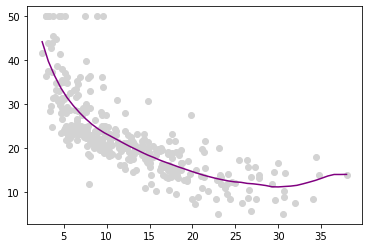

In [8]:
ks.draw_plot(model='epanech')

- tri-cube function kernel

In [9]:
pred = ks.predict(X_test,'tri')

In [10]:
mean_squared_error(pred,y_test)

27.59149126537781

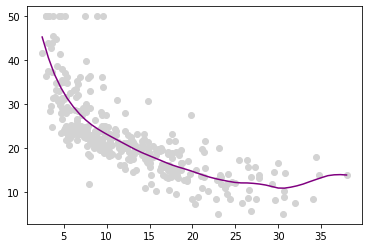

In [11]:
ks.draw_plot(model='tri')

- knn kernel

In [12]:
pred = ks.predict(X_test,'knn')

In [13]:
mean_squared_error(pred,y_test)

33.83232142787231

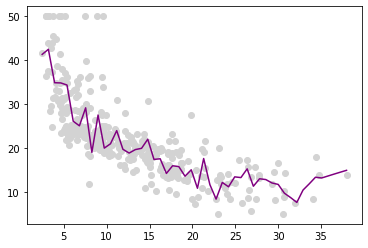

In [14]:
ks.draw_plot(model='knn')